In [5]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from google.colab import drive
drive.mount('/content/drive')

def preprocess():
    # Data paths
    train_data_file = 'sign_mnist_train.csv'
    test_data_file = 'sign_mnist_test.csv'
    folder_name = 'Project Data'

    # desktop_path = os.path.join(os.path.expanduser("~"), "Desktop")
    # train_data_path = os.path.join(desktop_path, folder_name, train_data_file)
    # test_data_path = os.path.join(desktop_path, folder_name, test_data_file)
    train_data_path = f'/content/drive/My Drive/{train_data_file}'
    test_data_path = f'/content/drive/My Drive/{test_data_file}'

    # Load data
    train_df = pd.read_csv(train_data_path)
    test_df = pd.read_csv(test_data_path)

    train_labels = train_df['label']
    train = train_df.drop(['label'], axis=1)

    test_labels = test_df['label']
    test = test_df.drop(['label'], axis=1)

    # Reshaping images
    train_images = train.values
    train_images = np.array([np.reshape(i, (28, 28)) for i in train_images])
    train_images = np.array([i.flatten() for i in train_images])

    test_images = test.values
    test_images = np.array([np.reshape(i, (28, 28)) for i in test_images])
    test_images = np.array([i.flatten() for i in test_images])

    # One hot encoding labels
    binrizer = LabelBinarizer()
    train_labels = binrizer.fit_transform(train_labels)
    test_labels = binrizer.fit_transform(test_labels)

    # Split into train and validation sets
    X_train, X_valid, y_train, y_valid = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

    # Normalize pixel values [0, 1]
    X_train = X_train/ 255.0
    X_valid = X_valid / 255.0

    # Reshape to 4D array (CNN)
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
    X_valid = X_valid.reshape(X_valid.shape[0], 28, 28, 1)
    test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

    return X_train, X_valid, test_images, y_train, y_valid, test_labels

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
X_train, X_valid, test_images, y_train, y_valid, test_labels = preprocess()

In [23]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization

model = Sequential()
model.add(Conv2D(16 , kernel_size=(3,3), activation='relu' , input_shape=(28,28,1)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(32 , kernel_size=(3,3), activation='relu' , input_shape=(28,28,1)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(64 , kernel_size=(3,3), activation='relu' , input_shape=(28,28,1)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(units = 24 , activation = 'softmax'))

In [24]:
# Experimentation
# 1 - epochs=10, batch_size=128, accuracy score=0.6865588399330731
# 2 - epoch=50, batch_size=128, accuracy score = 0.9125766871165644

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=50, batch_size=128)
model.save('cnn.h5')

Epoch 1/50
172/172 [==============================] - 4s 9ms/step - loss: 2.6681 - accuracy: 0.1943 - val_loss: 1.6721 - val_accuracy: 0.4912
Epoch 2/50
172/172 [==============================] - 1s 8ms/step - loss: 1.3619 - accuracy: 0.5490 - val_loss: 0.9352 - val_accuracy: 0.6984
Epoch 3/50
172/172 [==============================] - 1s 8ms/step - loss: 0.8780 - accuracy: 0.7041 - val_loss: 0.6445 - val_accuracy: 0.7964
Epoch 4/50
172/172 [==============================] - 1s 6ms/step - loss: 0.6285 - accuracy: 0.7857 - val_loss: 0.4770 - val_accuracy: 0.8406
Epoch 5/50
172/172 [==============================] - 1s 5ms/step - loss: 0.4573 - accuracy: 0.8490 - val_loss: 0.3183 - val_accuracy: 0.8991
Epoch 6/50
172/172 [==============================] - 1s 5ms/step - loss: 0.3308 - accuracy: 0.8887 - val_loss: 0.2126 - val_accuracy: 0.9383
Epoch 7/50
172/172 [==============================] - 1s 5ms/step - loss: 0.2445 - accuracy: 0.9201 - val_loss: 0.1722 - val_accuracy: 0.9474
Epoch 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Test model
y_pred = model.predict(test_images)
print("Test Accuracy:", accuracy_score(test_labels, y_pred.round()))

225/225 [==============================] - 1s 3ms/step
Test Accuracy: 0.9125766871165644


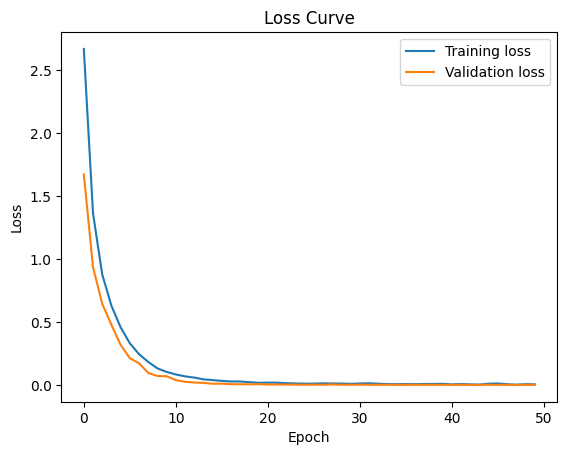

In [26]:
# Learning curve for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss Curve")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training loss', 'Validation loss'])
plt.show()